<a href="https://colab.research.google.com/github/cfoli/Kinematic-Decoding-4-BCI-Control/blob/main/neural_analysis_base_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description

---



### *Code base for performing inter-areal communication analysis based on intracortical neural signals from multiple brain regions*

In [2]:
def extract_fields(original_dict, fields):
    """
    Returns a new dictionary containing only the key-value pairs
    from original_dict whose keys are in the 'fields' list.
    April 1.25.T
    """
    return {key: original_dict[key] for key in fields if key in original_dict}


In [3]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

def time_varying_decoder(neural_data, trial_labels, window_size=5, mode='flatten',
                         model='svm', disable_progress_bar_TF=False, **model_kwargs):
    """
    Time-varying neural decoder using a sliding window and specified classifier.

    Parameters:
    - neural_data: N x T x R array (N: electrodes, T: time bins, R: trials)
    - grasp_type: 1 x R array of labels
    - window_size: sliding window size (in time bins)
    - mode: 'flatten' (N * window_size) or 'mean' (N)
    - model: one of ['svm', 'nb', 'tree', 'knn']
    - model_kwargs: extra keyword arguments passed to the classifier

    Returns:
    - time_points: list of center time bins for each window
    - decoding_accuracy: list of cross-validated decoding accuracies
    """
    N, T, R = neural_data.shape
    trial_labels = np.array(trial_labels).flatten()

    time_points = []
    decoding_accuracy = []

    t_range = range(window_size // 2, T - window_size // 2)

    # orange:FF9301, blue:00A2FF , green:61D835
    # print(f"Building neural decoders [mode = '{mode}', model = '{model}')...]")
    for t in tqdm(t_range, desc="Decoding Progress", colour='#00A2FF',disable=disable_progress_bar_TF):
        # Extract neural window: N x window_size x R
        window_data = neural_data[:, t - window_size // 2 : t + window_size // 2 + 1, :]

        if mode == 'flatten':
            X = window_data.reshape(N * window_size, R).T  # R x (N * window_size)
        elif mode == 'mean':
            X = window_data.mean(axis=1).T  # R x N
        else:
            raise ValueError("mode must be 'flatten' or 'mean'")

        y = trial_labels

        # Select classifier
        if model == 'svm':
            clf = SVC(kernel='rbf',**model_kwargs)
        elif model == 'nb':
            clf = GaussianNB(**model_kwargs)
        elif model == 'knn':
            clf = KNeighborsClassifier(**model_kwargs)
        else:
            raise ValueError("model must be one of: 'svm', 'nb', 'knn'")

        simple_imputer = SimpleImputer(strategy='mean')
        feature_scaler = StandardScaler()
        model_pipeline = make_pipeline(simple_imputer, feature_scaler, clf)

        # Cross-validated accuracy
        acc = cross_val_score(model_pipeline, X, y, cv=5).mean()

        time_points.append(t)
        decoding_accuracy.append(acc)

    return time_points, decoding_accuracy


In [41]:
def time_varying_decoder(neural_data, trial_labels, window_size=5, mode='flatten',
                         model='svm', disable_progress_bar_TF=False, **model_kwargs):
    """
    Time-varying neural decoder using a sliding window and specified classifier.

    Parameters:
    - neural_data: N x T x R array (N: electrodes, T: time bins, R: trials)
    - trial_labels: 1 x R array of labels
    - window_size: sliding window size (in time bins)
    - mode: 'flatten' (N * window_size) or 'mean' (N)
    - model: one of ['svm', 'nb', 'knn']
    - model_kwargs: extra keyword arguments passed to the classifier

    Returns:
    - time_points: list of center time bins for each window
    - decoding_accuracy: list of cross-validated decoding accuracies
    - electrode_weights: list of model weights per time bin (only for linear SVM)
    """
    N, T, R = neural_data.shape
    trial_labels = np.array(trial_labels).flatten()

    time_points = []
    decoding_accuracy = []
    electrode_weights = []

    t_range = range(window_size // 2, T - window_size // 2)

    for t in tqdm(t_range, desc="Decoding Progress", colour='#00A2FF', disable=disable_progress_bar_TF):
        # Extract windowed data
        window_data = neural_data[:, t - window_size // 2 : t + window_size // 2 + 1, :]

        if mode == 'flatten':
            X = window_data.reshape(N * window_size, R).T  # shape: (R, N * window_size)
        elif mode == 'mean':
            X = window_data.mean(axis=1).T  # shape: (R, N)
        else:
            raise ValueError("mode must be 'flatten' or 'mean'")

        y = trial_labels

        # Select classifier
        if model == 'svm':
            clf = SVC(kernel='linear', **model_kwargs)  # use linear kernel to get coef_
        elif model == 'nb':
            clf = GaussianNB(**model_kwargs)
        elif model == 'knn':
            clf = KNeighborsClassifier(**model_kwargs)
        else:
            raise ValueError("model must be one of: 'svm', 'nb', 'knn'")

        # Build pipeline
        simple_imputer = SimpleImputer(strategy='mean')
        feature_scaler = StandardScaler()
        model_pipeline = make_pipeline(simple_imputer, feature_scaler, clf)

        # Cross-validated decoding accuracy
        acc = cross_val_score(model_pipeline, X, y, cv=5).mean()
        decoding_accuracy.append(acc)
        time_points.append(t)

        # Fit model once to extract weights (only if SVM and linear)
        if model == 'svm':
            model_pipeline.fit(X, y)
            svm_model = model_pipeline.named_steps['svc']
            electrode_weights.append(svm_model.coef_.flatten())
            # print(f"svm_model.coef_.shape: {np.array(electrode_weights).shape}")
            # print(f"X shape: {X.shape}")
            # print(f"y shape: {y.shape}")
        else:
            electrode_weights.append(None)  # or np.nan for non-linear models

    return time_points, decoding_accuracy, electrode_weights


In [24]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

def fit_baseline_decoder(neural_data, trial_labels,num_perms=100,disable_progress_bar_TF=False):
    """
    Time-varying neural decoder using a sliding window and specified classifier.

    Parameters:
    - neural_data: N x T x R array (N: electrodes, T: time bins, R: trials)
    - grasp_type: 1 x R array of labels
    - window_size: sliding window size (in time bins)
    - mode: 'flatten' (N * window_size) or 'mean' (N)
    - model: one of ['svm', 'nb', 'tree', 'knn']
    - model_kwargs: extra keyword arguments passed to the classifier

    Returns:
    - time_points: list of center time bins for each window
    - decoding_accuracy: list of cross-validated decoding accuracies
    """

    X = neural_data
    y = np.array(trial_labels).flatten()

    acc_list = []
    for _ in tqdm(range(num_perms), desc="Fitting null decoders..", colour='#C4FFF9',disable=disable_progress_bar_TF):
      shuffled_indices = np.random.permutation(len(y))
      y_shuffled = y[shuffled_indices] # Shuffle labels

      classifier = SVC()

      simple_imputer = SimpleImputer(strategy='mean')
      feature_scaler = StandardScaler()
      model_pipeline = make_pipeline(simple_imputer, feature_scaler, classifier)

      # Cross-validated accuracy
      acc_list.append(cross_val_score(model_pipeline, X, y_shuffled, cv=5).mean())

    return np.mean(acc_list)


In [25]:

import numpy as np
from scipy.ndimage import gaussian_filter1d

def smooth_neural_data(neural_data, smooth_SD):
    """
    Smooths neural data along the time axis using a Gaussian filter.

    Parameters:
    - neural_data: ndarray of shape [N x T x R]
        Neural signal with N electrodes, T time points, and R trials.
    - smooth_SD: float
        Standard deviation for Gaussian smoothing (in time bins).

    Returns:
    - smoothed_data: ndarray of shape [N x T x R]
        Smoothed neural data.

    Date: April 2.25.W (CxF)
    """
    if smooth_SD <= 0:
        return neural_data.copy()  # no smoothing applied

    # Apply smoothing across time axis (axis=1)
    smoothed_data = gaussian_filter1d(neural_data, sigma=smooth_SD, axis=1)
    return smoothed_data


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_array_panel(neural_data, trial_labels, sampling_rate=1, grid_shape=None, time_range=None, figsize=(12, 10), show_ci=True, brain_area=None, task=None, label_type=None):
    """
    Efficiently plots trial-averaged time courses for all electrodes using fast matplotlib calls with seaborn styling.

    Parameters:
    - neural_data: ndarray [N x T x R]
        Neural data with N electrodes, T time points, and R trials.
    - trial_labels: array-like [R]
        Trial condition labels.
    - sampling_rate: float
        Sampling rate in Hz.
    - grid_shape: tuple (rows, cols), optional
        Grid shape for array panel. If None, uses a square layout.
    - time_range: tuple (start, end), optional
        Time range in seconds.
    - figsize: tuple
        Size of the figure.
    - show_ci: bool
        Whether to show 95% confidence intervals.

    Returns:
    - None

    Date: April 2.25.W (CxF)
    """
    sns.set(style="whitegrid", context="notebook")

    N, T, R = neural_data.shape
    trial_labels  = np.squeeze(trial_labels)
    unique_labels = np.unique(trial_labels)

    # # Set up time axis
    time = np.linspace(time_range[0], time_range[1], T) if time_range else np.arange(T) / sampling_rate

    # Define subplot layout
    if grid_shape is None:
        grid_cols = int(np.ceil(np.sqrt(N)))
        grid_rows = int(np.ceil(N / grid_cols))
    else:
        grid_rows, grid_cols = grid_shape

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=figsize, sharex=True, sharey=True, dpi=250)
    axes = axes.flatten()

    c_palette = 'Set2'
    if task in ['speech','concurrent_speech']:
        c_palette = 'viridis'
    elif task in ['cl_grasping','concurrent_grasping']:
        c_palette = 'plasma'

    color_map = dict(zip(unique_labels, sns.color_palette(c_palette, len(unique_labels))))

    cue_start = np.round(750/20)
    go_start  = np.round((750+1500)/20)

    # Precompute means and CI
    for i in range(N):
        ax = axes[i]
        for label in unique_labels:
            mask = (trial_labels == label)
            if np.sum(mask) == 0:
                continue
            data = neural_data[i, :, mask]  # NB: the shape here is (trials x T) not (T x trials)
            mean_trace = np.mean(data, axis=0)
            if show_ci:
                sem = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
                ci = 1.96 * sem
                ax.fill_between(time, mean_trace - ci, mean_trace + ci, color=color_map[label], alpha=0.25, linewidth=0)
            # print(f"time.shape: {time.shape}, mean_trace.shape: {mean_trace.shape}")
            ax.plot(time, mean_trace, color=color_map[label], linewidth=1.2)
            ax.axvline(x=cue_start, color='r', linestyle='--', label='Cue Onset',linewidth=0.5)
            ax.axvline(x=go_start, color='b', linestyle='--', label='Go Onset',linewidth=0.5)

        ax.set_title(f'Elec {i+1}', fontsize=6)
        ax.axis('off')

    # Shared legend
    from matplotlib.lines import Line2D
    legend_handles = [Line2D([0], [0], color=color_map[label], lw=1, label=str(label)) for label in unique_labels]
    fig.legend(handles=legend_handles, title=label_type if label_type is not None else "condition", loc='upper right',fontsize=6, title_fontsize=8)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    if brain_area is not None and task is not None:
        plt.suptitle(f"Trial-Averaged SBP | {brain_area} | {task}", fontsize=12)
    else:
      plt.suptitle("Trial-Averaged SBP", fontsize=12)
    plt.show()


### Load & Organize Data

---



In [7]:
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm

# Define session days, brain areas, and tasks
session_days = ['2024.11.08','2024.11.12','2024.12.02', '2024.12.03', '2024.12.05']
brain_areas  = ['AIP', 'IFG']
tasks        = ['cl_grasping', 'speech', 'concurrent']

# Dictionary to store all data
neural_data_dict = {}

# Flatten combinations for tqdm
all_combos = [(day, ba, t) for day in session_days for ba in brain_areas for t in tasks]

# orange:FF9301, blue:00A2FF , green:61D835
for session_day, brain_area, task in tqdm(all_combos, desc="Loading .mat files", colour='#61D835'):
    file_path = f'/content/drive/MyDrive/Inter-areal Communication Analysis/Data/{session_day}/{brain_area}/{task}/trialmats_{task}_{brain_area}.mat'

    mat_data = loadmat(file_path)

    # Define and extract relevant fields based on task type
    if task == 'cl_grasping':
        valid_fields = [f'trialmat{brain_area.lower()}', 'handOpenOrClose', 'graspType']
        neural_data_dict[(session_day, brain_area, 'grasping')] = extract_fields(mat_data, valid_fields)

    elif task == 'speech':
        valid_fields = [f'trialmat{brain_area.lower()}', 'overtOrcovert']
        neural_data_dict[(session_day, brain_area, task)] = extract_fields(mat_data, valid_fields)

    elif task == 'concurrent':
        # Save concurrent grasping
        valid_fields = [f'trialmat{brain_area.lower()}', 'handOpenOrClose', 'graspType']
        neural_data_dict[(session_day, brain_area, f'{task}_grasping')] = extract_fields(mat_data, valid_fields)

        # Save concurrent speech
        valid_fields = [f'trialmat{brain_area.lower()}', 'overtOrcovert']
        neural_data_dict[(session_day, brain_area, f'{task}_speech')] = extract_fields(mat_data, valid_fields)


Loading .mat files: 100%|██████████| 30/30 [03:36<00:00,  7.21s/it]


In [ ]:
neural_data_dict.keys()

### Select and Smooth Data for Example Session

---



In [28]:
session_day = '2024.11.12' # 2024.12.02, '2024.11.12','2024.12.02', '2024.12.03', '2024.12.05'
brain_area  = 'IFG' # 'IFG'
task        = 'grasping' # speech, grasping, concurrent_speech, concurrent_grasping
label_type  = 'overtOrcovert' if task in ['speech','concurrent_speech'] else 'handOpenOrClose' # handOpenOrClose, graspType
smooth_neural_data_TF = True

neural_data   = neural_data_dict[(session_day, brain_area, task)][f'trialmat{brain_area.lower()}']
trial_labels  = neural_data_dict[(session_day, brain_area, task)][label_type]

if smooth_neural_data_TF:
    smooth_SD = 4
    neural_data = smooth_neural_data(neural_data, smooth_SD)


### Plot Spike Panel

---



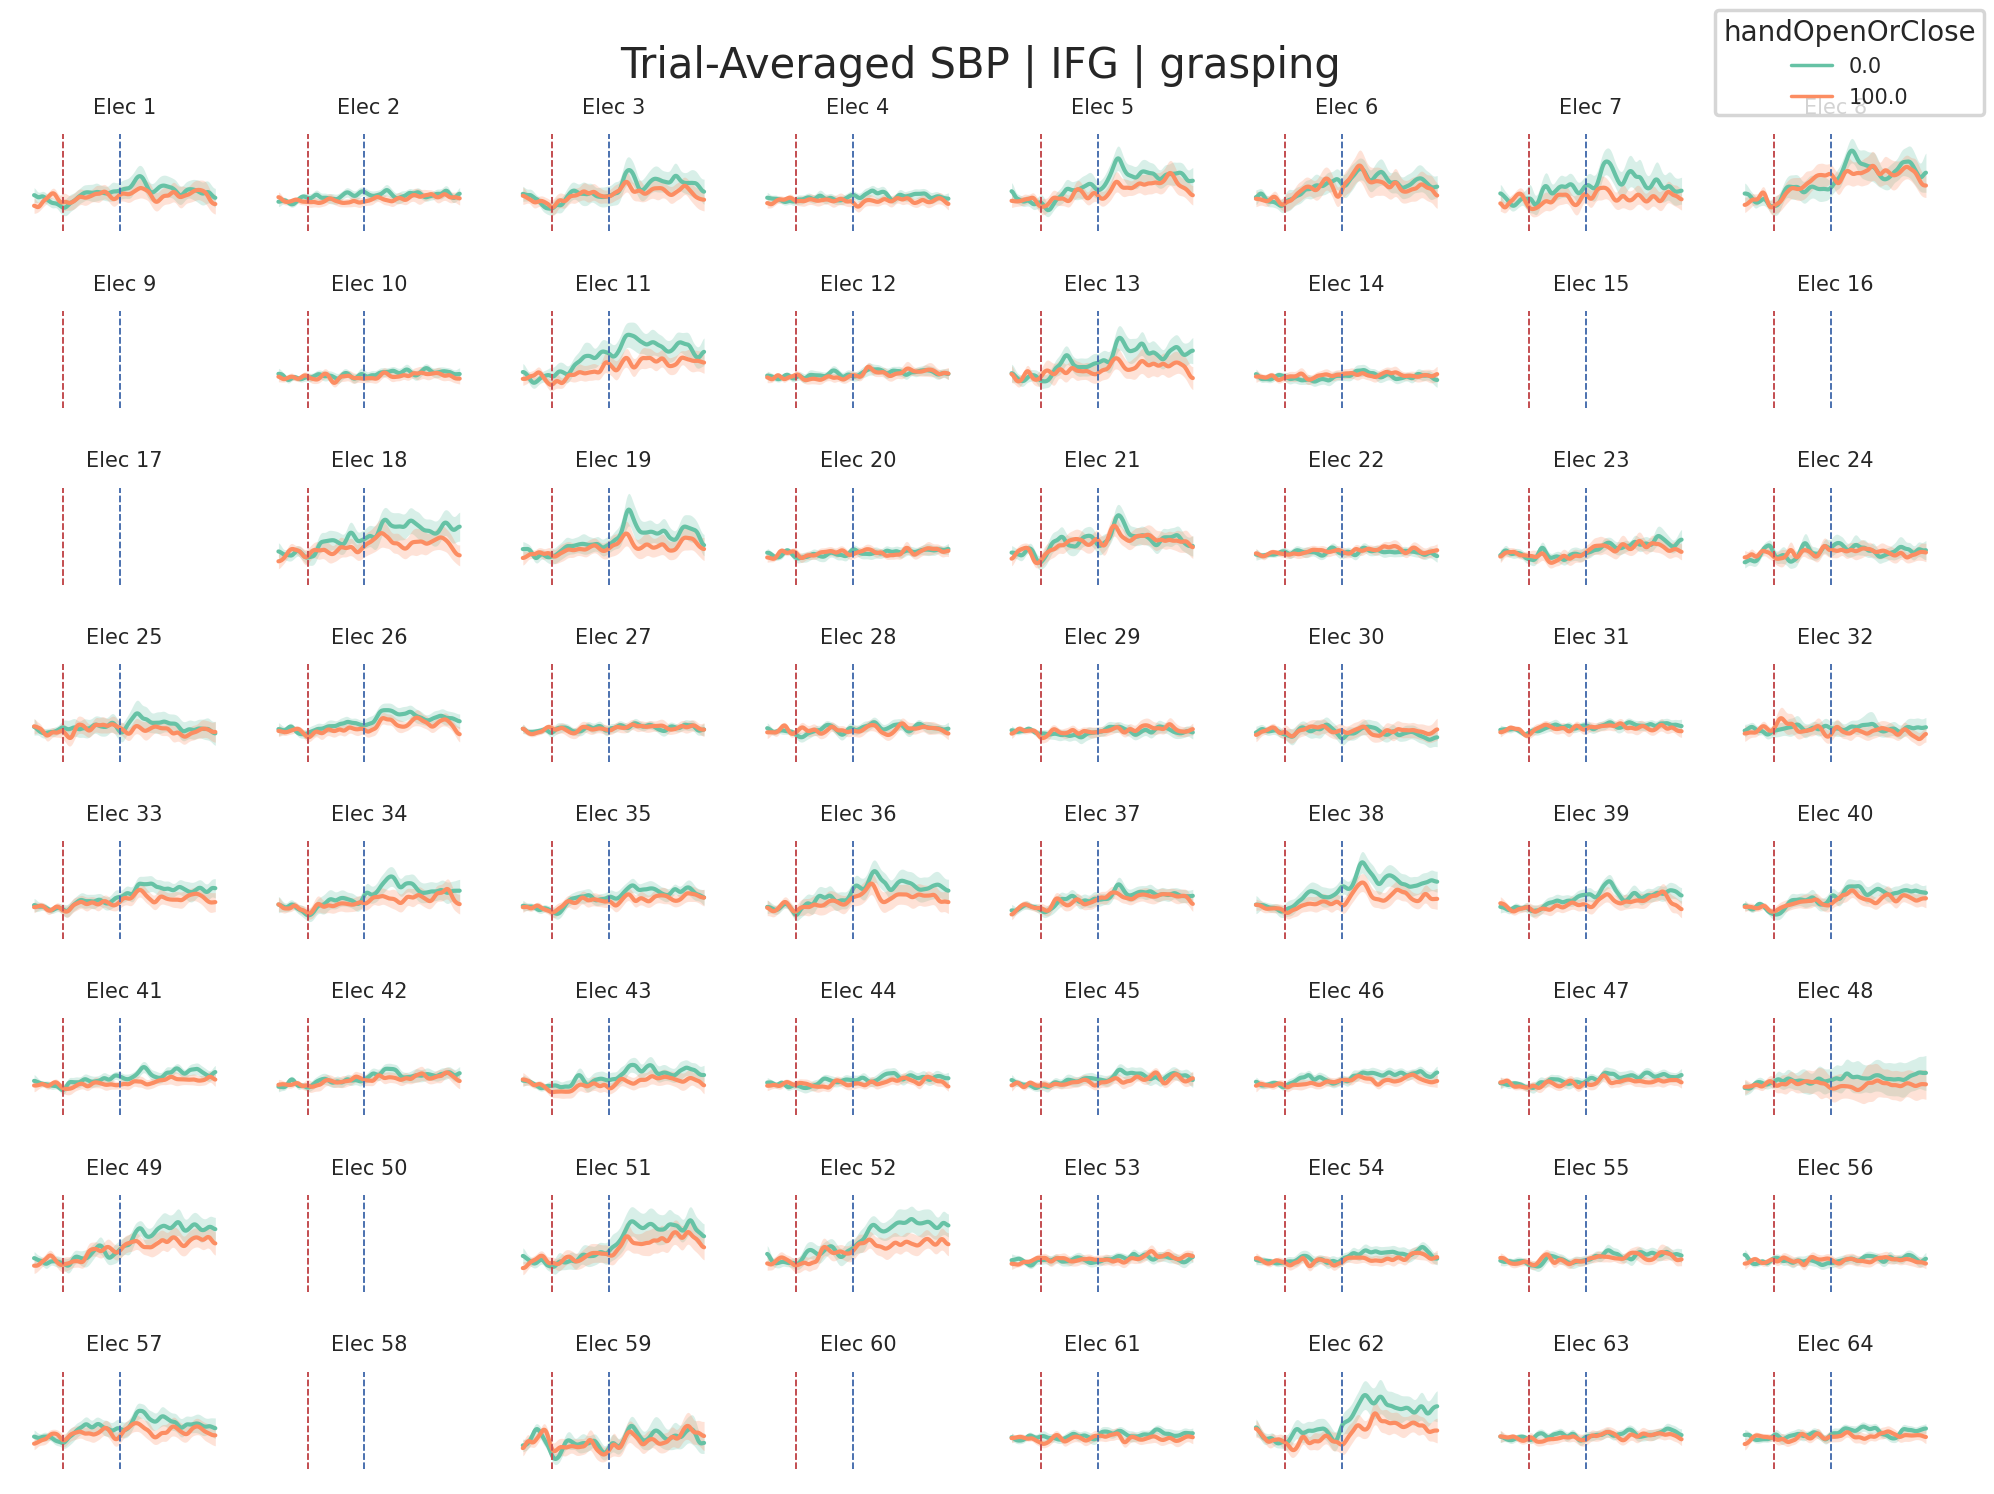

In [32]:

plot_array_panel(neural_data, trial_labels,
                 show_ci    = True,
                 brain_area = brain_area,
                 task       = task,
                 label_type = label_type,
                 figsize    = (8, 6))


### Decoding Pipeline (One Session)

---



In [29]:
import numpy as np

# Identify "valid" electrodes
valid_electrodes = ~np.all(np.isnan(neural_data), axis=(1, 2))  # shape: (N,)

# Filter neural_data to keep only valid electrodes
neural_data_valid = neural_data[valid_electrodes, :, :]  # shape: (N_valid, T, R)
print(f"Shape of neural_data_valid: {neural_data_valid.shape}")


Shape of neural_data_valid: (57, 237, 107)


Fit decoder

In [40]:
neural_data_valid.shape

(57, 237, 107)

In [42]:
window_size = 5
time_pts, accs, electrode_weights = time_varying_decoder(neural_data_valid, trial_labels, window_size=window_size, model='svm',mode='mean',disable_progress_bar_TF=False)


Decoding Progress: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]


array([43, 50, 22, 26, 12, 40,  8,  4,  7, 47, 14,  5, 30, 39, 37, 42, 25,
       29,  3, 51, 17, 20, 23, 48, 18, 55, 24, 27, 15, 31, 19, 10, 49, 41,
       45, 28,  2, 35,  6,  1, 52, 53, 11, 16, 56,  9,  0, 54, 38, 32, 36,
       13, 21, 46, 34, 33, 44])

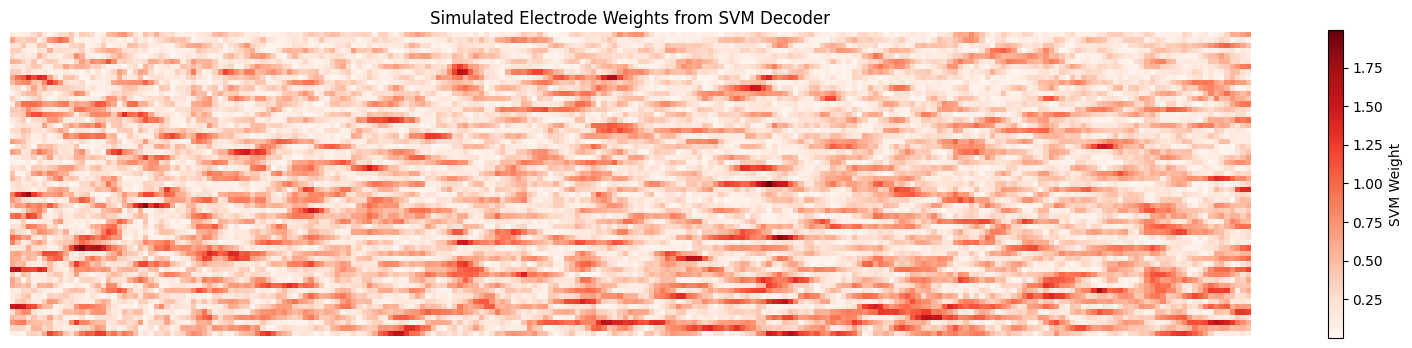

In [64]:
# Get electrode weights
weights_2d = np.array(electrode_weights).T
idx = np.argsort(np.mean(abs(weights_2d),axis=1))

# Plot heatmap of electrode weights
plt.figure(figsize=(20, 4))
plt.imshow(abs(weights_2d[idx,:]), cmap='Reds', aspect='equal')
plt.colorbar(label='SVM Weight')
plt.title('Simulated Electrode Weights from SVM Decoder')
plt.axis('off')
plt.show()

Fit chance decoder via permutation

In [ ]:

neural_data_valid_baseline = np.mean(neural_data_valid[:,:25,:],axis=1).T # compute mean activity within 500ms of baseline
null_acc = fit_baseline_decoder(neural_data_valid_baseline, trial_labels, num_perms=100, disable_progress_bar_TF=False)
# print(f"\nNull accuracy: {100*null_acc:.2f}%")


Plot decoding accuracies

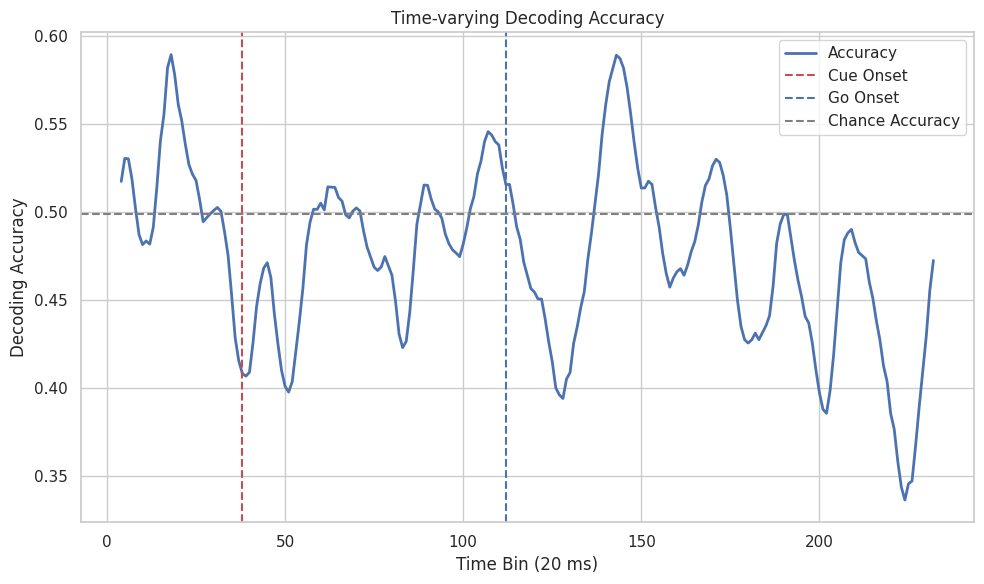

In [63]:
import matplotlib.pyplot as plt

smooth_window_size = 5
accs_smooth = np.convolve(accs, np.ones(smooth_window_size)/smooth_window_size, mode='valid')

# Match time points to smoothed data
valid_len   = len(accs) - smooth_window_size + 1
time_smooth = time_pts[(smooth_window_size // 2) : (smooth_window_size // 2 + valid_len)]

cue_start = np.round(750/20)
go_start  = np.round((750+1500)/20)

plt.figure(figsize=(10, 6))
plt.plot(time_smooth, accs_smooth, linewidth=2,label='Accuracy')
plt.axvline(x=cue_start, color='r', linestyle='--', label='Cue Onset')
plt.axvline(x=go_start, color='b', linestyle='--', label='Go Onset')
plt.axhline(y=null_acc, color='gray', linestyle='--', label='Chance Accuracy')

plt.xlabel('Time Bin (20 ms)')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Decoding Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


### Decoding Pipeline (All Sessions)

---



In [9]:
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm

# Define session days, brain areas, and tasks
session_days = ['2024.11.08','2024.11.12','2024.12.02', '2024.12.03', '2024.12.05'] # ['2024.11.08','2024.11.12','2024.12.02', '2024.12.03', '2024.12.05']
brain_areas  = ['AIP', 'IFG']
tasks        = ['grasping', 'concurrent_grasping'] #['grasping', 'speech', 'concurrent_speech', 'concurrent_grasping']
#
decoding_results = {}

# Flatten combinations for tqdm
all_combos = [(day, ba, t) for day in session_days for ba in brain_areas for t in tasks]

# orange:FF9301, blue:00A2FF , green:61D835
for session_day, brain_area, task in tqdm(all_combos, desc="Fitting decoders across tasks and sessions..", colour='#EF5FA7'):

    # neural_data_dict[(session_day, brain_area, f'{task}_speech')] = extract_fields(mat_data, valid_fields)

    label_type  = 'overtOrcovert' if task in ['speech','concurrent_speech'] else 'graspType'
    # handOpenOrClose, graspType

    neural_data   = neural_data_dict[(session_day, brain_area, task)][f'trialmat{brain_area.lower()}']
    trial_labels  = neural_data_dict[(session_day, brain_area, task)][label_type]

    # if label_type == 'graspType':
    #   trial_labels_temp = neural_data_dict[(session_day, brain_area, task)]['handOpenOrClose']
    #   label_mask = trial_labels_temp==0.0 # select only hand closing
    #   trial_labels = trial_labels[label_mask]
    #   neural_data = neural_data[:,:,label_mask.flatten()]

    neural_data   = smooth_neural_data(neural_data, smooth_SD=4)

    # Identify "valid" electrodes
    valid_electrodes  = ~np.all(np.isnan(neural_data), axis=(1, 2))  # shape: (N,)
    neural_data_valid = neural_data[valid_electrodes, :, :]  # shape: (N_valid, T, R)

    _, accs = time_varying_decoder(neural_data_valid, trial_labels, window_size=5, model='knn',disable_progress_bar_TF=True)

    ## ----------------------
    smooth_window_size = 5
    accs = np.convolve(accs, np.ones(smooth_window_size)/smooth_window_size, mode='valid')
    ## ----------------------

    neural_data_valid_baseline = np.mean(neural_data_valid[:,:25,:],axis=1).T # compute mean activity within 500ms of baseline
    null_acc = fit_baseline_decoder(neural_data_valid_baseline, trial_labels,num_perms=100, disable_progress_bar_TF=True)

    decoding_results[(session_day, brain_area, task)] = {
        'accuracy': accs,
        'null_accuracy': null_acc,
        'valid_electrodes': np.where(valid_electrodes)
    }


Fitting decoders across tasks and sessions..: 100%|██████████| 20/20 [04:56<00:00, 14.82s/it]


In [16]:
neural_data.shape

(64, 237, 76)

In [16]:
decoding_results.keys()

dict_keys([('2024.11.08', 'AIP', 'grasping'), ('2024.11.08', 'AIP', 'speech'), ('2024.11.08', 'AIP', 'concurrent_speech'), ('2024.11.08', 'AIP', 'concurrent_grasping'), ('2024.11.08', 'IFG', 'grasping'), ('2024.11.08', 'IFG', 'speech'), ('2024.11.08', 'IFG', 'concurrent_speech'), ('2024.11.08', 'IFG', 'concurrent_grasping'), ('2024.11.12', 'AIP', 'grasping'), ('2024.11.12', 'AIP', 'speech'), ('2024.11.12', 'AIP', 'concurrent_speech'), ('2024.11.12', 'AIP', 'concurrent_grasping'), ('2024.11.12', 'IFG', 'grasping'), ('2024.11.12', 'IFG', 'speech'), ('2024.11.12', 'IFG', 'concurrent_speech'), ('2024.11.12', 'IFG', 'concurrent_grasping'), ('2024.12.02', 'AIP', 'grasping'), ('2024.12.02', 'AIP', 'speech'), ('2024.12.02', 'AIP', 'concurrent_speech'), ('2024.12.02', 'AIP', 'concurrent_grasping'), ('2024.12.02', 'IFG', 'grasping'), ('2024.12.02', 'IFG', 'speech'), ('2024.12.02', 'IFG', 'concurrent_speech'), ('2024.12.02', 'IFG', 'concurrent_grasping'), ('2024.12.03', 'AIP', 'grasping'), ('2024

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_decoding_accuracies(results, brain_areas, tasks, ylim=None, window_times=None, palette="viridis"):
    """
    Plot decoding accuracies (mean ± SEM) across tasks and brain areas over time.

    Parameters:
    -----------
    results : dict
        Dictionary with keys (session_day, brain_area, task) and values containing:
            - 'accuracy': list or np.array of decoding accuracy over time.
            - 'null_accuracy': baseline/null accuracy for comparison.

    brain_areas : list of str
        Brain areas to include, each will get its own subplot.

    tasks : list of str
        Task types to group within each subplot.

    window_times : array-like or None
        Optional array of time points for the x-axis. If None, uses indices.

    palette : str or list
        Seaborn color palette name (e.g., 'colorblind', 'Set2') or a list of colors.
        Must match the number of tasks.

    Returns:
    --------
    None. Displays the figure.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, dpi=250)

    if window_times is None:
        sample_key   = next(iter(results))
        acc_len      = len(results[sample_key]['accuracy'])
        window_times = np.arange(acc_len)

    # Handle color palette
    if isinstance(palette, str):
        colors = sns.color_palette(palette, len(tasks))
    else:
        colors = palette

    cue_start = np.round(750/20)
    go_start  = np.round((750+1500)/20)

    for idx, brain_area in enumerate(brain_areas):
        ax = axes[idx]

        for i, task in enumerate(tasks):
            acc_list = []
            null_list = []

            for key in results:
                s_day, b_area, tsk = key
                if b_area == brain_area and tsk == task:
                    acc_list.append(results[key]['accuracy'])
                    null_list.append(results[key]['null_accuracy'])

            if acc_list:
                acc_array = np.stack(acc_list)  # shape: (num_sessions, time)
                mean_acc  = np.mean(acc_array, axis=0)
                sem_acc   = np.std(acc_array, axis=0, ddof=1) / np.sqrt(acc_array.shape[0])
                mean_null = np.mean(null_list)

                ax.plot(window_times, mean_acc, label=task, color=colors[i], linewidth=1.5)
                ax.fill_between(window_times, mean_acc - sem_acc, mean_acc + sem_acc, alpha=0.2, color=colors[i])
                ax.axhline(mean_null, linestyle='--', linewidth=1, color=colors[i], alpha=0.5)

        ax.axvline(x=cue_start, color='r', linestyle='--', label='Cue Onset',linewidth=0.75)
        ax.axvline(x=go_start, color='b', linestyle='--', label='Go Onset',linewidth=0.75)
        ax.set_title(brain_area, fontsize=12)
        ax.set_xlabel("Time (window)", fontsize=10)
        ax.grid(False)

        if ylim is not None:
          ax.set_ylim(ylim[0], ylim[1])

        ax.tick_params(axis='both', labelsize=10)  # <-- Increase tick label size

        if idx == 0:
            ax.set_ylabel("Accuracy", fontsize=10)
        ax.legend(title="Task", fontsize=8)

    fig.suptitle("Time-Resolved Decoding Accuracy", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


In [1]:

plot_decoding_accuracies(decoding_results, brain_areas=['AIP','IFG'], tasks=['grasping', 'concurrent_grasping'], palette="plasma", ylim=(0.4, 0.7))
# ['grasping', 'speech']


NameError: name 'plot_decoding_accuracies' is not defined

In [10]:
trial_labels.shape

(1, 107)

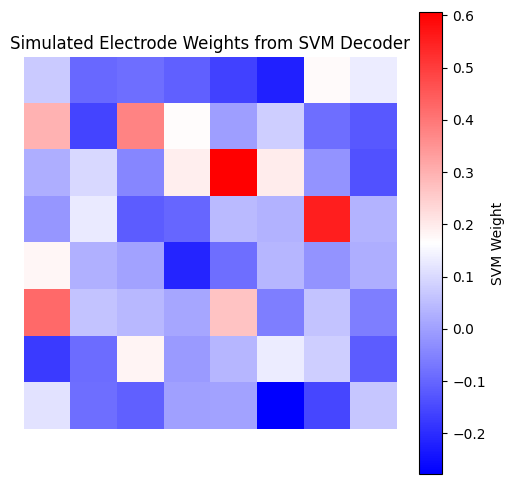

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Set seed for reproducibility
np.random.seed(0)

# Parameters
n_trials = 100
n_electrodes = 64
grid_shape = (8, 8)

# Simulate class labels (binary)
y = np.random.choice([0, 1], size=n_trials)

# Simulate neural data (random noise + class-specific mean shift)
X = np.random.randn(n_trials, n_electrodes)

# Add class-specific activity patterns to a few electrodes
signal_electrodes = [10, 20, 30, 40]
for i in signal_electrodes:
    X[y == 1, i] += 1.5  # boost signal for class 1

# Train linear SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

# Get electrode weights
weights = svm.coef_.flatten()
weights_2d = weights.reshape(grid_shape)

# Plot heatmap of electrode weights
plt.figure(figsize=(6, 6))
plt.imshow(weights_2d, cmap='bwr', aspect='equal')
plt.colorbar(label='SVM Weight')
plt.title('Simulated Electrode Weights from SVM Decoder')
plt.axis('off')
plt.show()
